In [1]:
import cv2
import numpy as np
import os, sys
import matplotlib.pyplot as plt 
from skimage.transform import warp, AffineTransform

# CURR_PATH = os.path.dirname(os.path.abspath(__file__))+"/"
CURR_PATH = "/home/feiyu/baxterws/src/winter_prj/auto_collect/src_data_aug/"
BACKGROUND = CURR_PATH + "../data/background/"

In [35]:
def imshow(img):
    img_tmp = img.copy()
    plt.imshow(img_tmp)
    plt.show()
    
def cv2_imshow(img):
    cv2.imshow("image", image)
    cv2.waitKey()
    cv2.destroyAllWindows()
    
def show2(i1, i2, size=(6,12)):
    plt.figure(figsize=size)
    plt.subplot(121)
    plt.imshow(i1)
    plt.subplot(122)
    plt.imshow(i2)

def show3(i1, i2, i3, size=(6,12)):
    plt.figure(figsize=size)
    plt.subplot(131)
    plt.imshow(i1)
    plt.subplot(132)
    plt.imshow(i2) 
    plt.subplot(133)
    plt.imshow(i3)
    
def show22(i1, i2, i3, i4):
    # plt.figure(figsize=(10,14))
    plt.subplot(221)
    plt.imshow(i1)
    plt.subplot(222)
    plt.imshow(i2)
    plt.subplot(223)
    plt.imshow(i3)
    plt.subplot(224)
    plt.imshow(i4)

In [36]:
def add_color(img, mask, channel, mask_value = 1):
    img_disp = img.copy()
    i_sub = img_disp[..., channel]
    i_sub[np.where(mask==mask_value)] = 255
    return img_disp

def getBbox(mask):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def cropImg(img, rmin, rmax, cmin, cmax):
    if len(img.shape)==2:
        return img[rmin:rmax, cmin:cmax]
    else:
        return img[rmin:rmax, cmin:cmax, :]


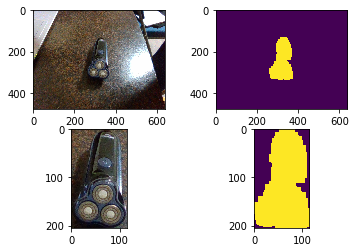

In [37]:
# Load training images
folder = CURR_PATH + "../data/03-06/"
mask0 = cv2.imread(folder + "mask/00001_mask.png", cv2.IMREAD_UNCHANGED)==1
img0 =  cv2.imread(folder + "image/00001_image.png")
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)

# Load background image
bg = cv2.imread(BACKGROUND + "001.jpg")
bg = cv2.resize(bg, (0,0), fx=0.5, fy=0.5)

# Crop out object
rmin, rmax, cmin, cmax = getBbox(mask0)
img = cropImg(img0, rmin, rmax, cmin, cmax)
mask = cropImg(mask0, rmin, rmax, cmin, cmax)

# Show
show22(img0, mask0, img, mask)    

In [85]:
def randint(num):
    return int(np.random.random()*num)
def randval(num):
    return np.random.random()*num
def randval_normal(num):
    # return np.random.normal()*num
    return np.random.random()*num*2 - num

In [115]:

x0 = img.shape[1]
y0 = img.shape[0]
x1 = bg.shape[1]
y1 = bg.shape[0]

# translation
def createNewImgMask(img, mask):
    
    # Other inputs: size of src/dst images: x0, y0, x1, y1

    scale_x = 1.0 + randval_normal(0.3)
    scale_y = 1.0 + randval_normal(0.3)
    x00 = x0 * scale_x
    y00 = y0 * scale_y
    rotation = randval_normal(0.5)
    shear = randval_normal(0.1)
    tx = (x1 - x00)/2.0 + randval_normal((x1 - x00)/2.0)
    ty = (y1 - y00)/2.0 + randval_normal((y1 - y00)/2.0)
    
    # print("transformation: ", scale_x,scale_y,rotation,shear,tx,ty)
    
    t1 = AffineTransform(translation=(-x00/2, -y00/2))
    t2 = AffineTransform(scale=(scale_x, scale_y), rotation=rotation, shear=shear)
    t3 = AffineTransform(translation=(+x00/2+tx, +y00/2+ty))
    
    def get(t):
        return t.params
    t = get(t1).dot(get(t2)).dot(get(t3))
    tform = AffineTransform(t)
    
    img_new = warp(img, tform.inverse, output_shape=(y1, x1))
    mask_new = warp(mask, tform.inverse, output_shape=(y1, x1))
    
    return img_new, mask_new

def createNewImage(src_img, src_mask, dst):
    src_img_new, src_mask_new = createNewImgMask(src_img, src_mask)
    dst_new = dst.copy()
    idx = np.where(src_mask_new==1)
    dst_new[idx] = (src_img_new[idx]*255).astype(np.uint8)
    return dst_new, src_img_new, src_mask_new

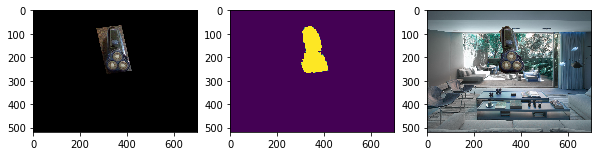

In [116]:
dst_new, src_img_new, src_mask_new = createNewImage(img, mask, bg)
show3(src_img_new, src_mask_new, dst_new, size=(10, 30))

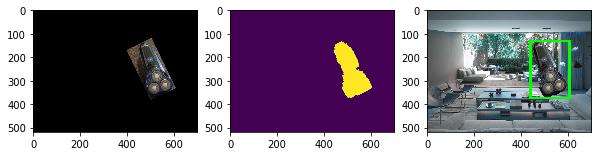

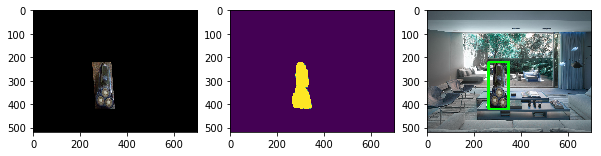

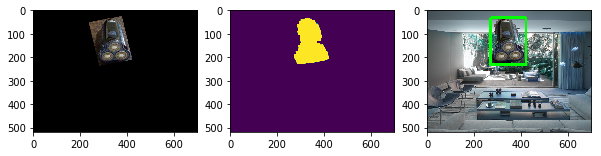

In [118]:
N = 3
for i in range(N):
    dst, src_img_new, src_mask_new = createNewImage(img, mask, bg)
    
    rmin, rmax, cmin, cmax = getBbox(src_mask_new)
    x, y, w, h = cmin, rmin, cmax-cmin, rmax-rmin
    dst = cv2.rectangle(dst,(x,y),(x+w,y+h),(0,255,0),10)
    
    show3(src_img_new, src_mask_new, dst, size=(10, 30))